In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomNormal, RandomUniform
from tensorflow.keras.optimizers import Adam

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
help(np.random.choice)

Help on built-in function choice:

choice(...) method of numpy.random.mtrand.RandomState instance
    choice(a, size=None, replace=True, p=None)
    
    Generates a random sample from a given 1-D array
    
    .. versionadded:: 1.7.0
    
    .. note::
        New code should use the ``choice`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    Parameters
    ----------
    a : 1-D array-like or int
        If an ndarray, a random sample is generated from its elements.
        If an int, the random sample is generated as if it were ``np.arange(a)``
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which case a
        single value is returned.
    replace : boolean, optional
        Whether the sample is with or without replacement. Default is True,
        meaning that a value of ``a`` can be selected mu

In [11]:
dim = 20
n_mem = 10

# x = np.linspace(-2, 2, 3, dtype=np.float32)
# temp = np.stack(np.meshgrid(*(axis for axis in [x]*dim) ), -1).reshape(-1,dim)
coords = np.random.choice([-2.,0.,2.], size=(n_mem, dim))

In [12]:
import scipy.spatial.distance
# coords = temp[np.random.choice(range(len(temp)), n_mem, replace=False)]
dists = scipy.spatial.distance.pdist(coords)
print(f'min dist = {min(dists)}, max dist = {max(dists)}')

min dist = 7.211102550927978, max dist = 13.856406460551018


In [13]:
from sklearn.mixture import GaussianMixture
import scipy.linalg

gmm = GaussianMixture(n_components=n_mem, covariance_type='full')
gmm.weights_ = np.ones(n_mem)/n_mem
gmm.means_ = coords
gmm.covariances_ = np.zeros((n_mem,dim,dim))

scale = 4  # eigenvalue control for random covariance matrices
for i in range(len(gmm.covariances_)):
    eigval = np.random.uniform(size=dim)*scale
    q, _ = scipy.linalg.qr(np.random.rand(dim, dim))
    gmm.covariances_[i] = q.T @ np.diag(eigval) @ q

M, labels = gmm.sample(5000)
print(f'Sample point value range: {np.min(M)}, {np.max(M)}')

Sample point value range: -7.873593315959738, 9.246283810960218


### UMAP Visualization

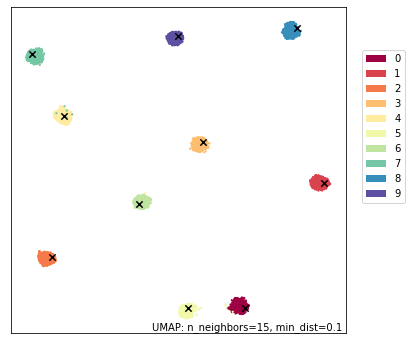

In [14]:
import umap
import umap.plot

mapper = umap.UMAP().fit(M)
ax = umap.plot.points(mapper, labels=labels)
legend = ax.get_legend()
ax.legend(legend.legendHandles, (x.get_text() for x in legend.get_texts()), loc=(1.05,0.4))
# add in the embeddings of the means
embedding = mapper.transform(gmm.means_)
ax.scatter(embedding[:,0], embedding[:,1], c='k', s=40, marker='x')
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.show()

## MHN

In [17]:
MS = 2                  # mask size

Ns, N1 = M.shape
N2 = n_mem

mu = 0.01           # parameters for weights initialization
sigma = 0.01
N_steps = 3         # number of HN iterations

beta = 0.5           # initial inv. temperature parameter setting
R0 = 5              # initial radius setting

batch_size = 100
eps = 0.04          # ADAM lr
N_ep = 400        # epochs

alpha = 0.4            # initial alpha setting (dt/tau)

In [18]:
class MHN_WITH_1_HIDDEN_LAYER(tf.keras.layers.Layer):
    def __init__(self, N1=N1, N2=N2, **kwargs):
        super().__init__(**kwargs)
        self.N1 = N1
        self.N2 = N2        

    def build(self, input_shape):
        self.kernel = self.add_weight(
            "kernel",
            shape=[self.N1, self.N2],
            initializer=RandomNormal(mean=mu, stddev=sigma, seed=None)
        )
        self.beta = self.add_weight(
            "beta",
            shape=[1, 1],
            initializer=RandomNormal(mean=beta, stddev=0.01, seed=None)
        )
        self.R = self.add_weight(
            "R",
            shape=[1, 1],
            initializer=RandomNormal(mean=R0, stddev=0.01, seed=None)
        )
        self.alpha = self.add_weight(
            "alpha",
            shape=[1, 1],
            initializer=RandomNormal(mean=alpha, stddev=0.01, seed=None)
        )
        
        super().build(input_shape)

    def call(self, v, mask):   # one iteration of visible unit update
        nc = tf.sqrt(tf.reduce_sum(tf.square(self.kernel), axis=[0]))
        Mem = self.kernel/nc*self.R       # Memories
        
        h = tf.matmul(v,Mem)              # hidden units
        SM = tf.nn.softmax(self.beta*h)
        U = tf.matmul(SM, tf.transpose(Mem)) - v
        return [v + self.alpha*U*mask, SM]
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'N1': self.N1,
            'N2': self.N2,
        })
        return config
                    

In [19]:
tf.keras.backend.clear_session()

input_mask = Input(shape=[N1])
input1 = Input(shape=[N1])
MHN_cell = MHN_WITH_1_HIDDEN_LAYER(N1, N2)

# define model
x, SM = MHN_cell(input1, input_mask)
for _ in range(N_steps-1):
    x, SM = MHN_cell(x, input_mask)

model = Model(inputs=[input1, input_mask], outputs=x)

optimizer = Adam(learning_rate=eps)

train_dataset = tf.data.Dataset.from_tensor_slices((M, M))
train_dataset = train_dataset.shuffle(Ns).batch(batch_size)

2022-07-06 15:51:04.297831: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 15:51:05.117100: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38274 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:17:00.0, compute capability: 8.0


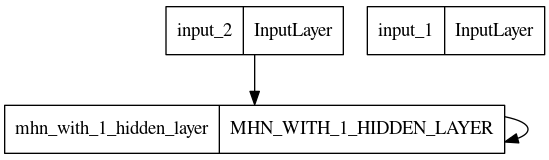

In [20]:
tf.keras.utils.plot_model(model)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 mhn_with_1_hidden_layer (MHN_W  [(None, 20),        203         ['input_2[0][0]',                
 ITH_1_HIDDEN_LAYER)             (None, 10)]                      'input_1[0][0]',                
                                                                  'mhn_with_1_hidden_layer[0][0]',
                                                                  'input_1[0][0]',            

In [22]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = ' - '.join(["{}: {:.4f}".format('loss', m) for m in [loss] + (metrics or [])])
    end = '' if iteration < total else '\n'
    print('\r{}/{} - '.format(iteration, total) + metrics, end=end)

def mean_squared_error(y_true, y_pred):
    loss = tf.reduce_mean(tf.square(y_true-y_pred))*N1/MS
    return loss

In [23]:
def draw_weights(fig, mem, gmm_means=gmm.means_, mapper=mapper):
    gmm_means = mapper.transform(gmm_means)
    mem = mapper.transform(mem)
    fig.clf()
    plt.scatter(gmm_means[:,0], gmm_means[:,1])
    plt.scatter(mem[:,0],mem[:,1])
    fig.canvas.draw()

<IPython.core.display.Javascript object>


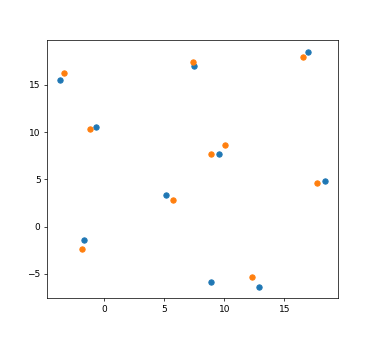

Epoch 1/400


2022-07-06 15:51:39.250880: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


5000/5000 - loss: 1.5191
Current beta is:  0.4918205 , current R is:  5.196729 , current alpha is:  0.5604929
Epoch 2/400
5000/5000 - loss: 1.6871
Current beta is:  0.45071644 , current R is:  5.3997564 , current alpha is:  0.6755086
Epoch 3/400
5000/5000 - loss: 1.6190
Current beta is:  0.44424546 , current R is:  5.598959 , current alpha is:  0.74510545
Epoch 4/400
5000/5000 - loss: 1.5665
Current beta is:  0.38424012 , current R is:  5.7428536 , current alpha is:  0.7765873
Epoch 5/400
5000/5000 - loss: 1.6238
Current beta is:  0.33985227 , current R is:  5.8615813 , current alpha is:  0.7910689
Epoch 6/400
5000/5000 - loss: 1.6514
Current beta is:  0.27338812 , current R is:  6.0023694 , current alpha is:  0.81601614
Epoch 7/400
5000/5000 - loss: 1.5613
Current beta is:  0.2693948 , current R is:  6.1194925 , current alpha is:  0.83223104
Epoch 8/400
5000/5000 - loss: 1.7680
Current beta is:  0.21263975 , current R is:  6.1878915 , current alpha is:  0.8304079
Epoch 9/400
5000/5000

5000/5000 - loss: 1.6082
Current beta is:  0.20624837 , current R is:  7.253701 , current alpha is:  0.7153236
Epoch 68/400
5000/5000 - loss: 1.6162
Current beta is:  0.23150375 , current R is:  7.272094 , current alpha is:  0.7282562
Epoch 69/400
5000/5000 - loss: 1.4602
Current beta is:  0.21850204 , current R is:  7.2750673 , current alpha is:  0.7334637
Epoch 70/400
5000/5000 - loss: 1.4122
Current beta is:  0.21842642 , current R is:  7.268642 , current alpha is:  0.7271885
Epoch 71/400
5000/5000 - loss: 1.6073
Current beta is:  0.22518596 , current R is:  7.2724643 , current alpha is:  0.7221457
Epoch 72/400
5000/5000 - loss: 1.5704
Current beta is:  0.2212133 , current R is:  7.2586236 , current alpha is:  0.69904643
Epoch 73/400
5000/5000 - loss: 1.4853
Current beta is:  0.24265799 , current R is:  7.2760777 , current alpha is:  0.7283795
Epoch 74/400
5000/5000 - loss: 1.5089
Current beta is:  0.20973398 , current R is:  7.2403007 , current alpha is:  0.6749926
Epoch 75/400
500

5000/5000 - loss: 1.3684
Current beta is:  0.19371925 , current R is:  7.3614087 , current alpha is:  0.66719514
Epoch 134/400
5000/5000 - loss: 1.6115
Current beta is:  0.23285556 , current R is:  7.350889 , current alpha is:  0.6600601
Epoch 135/400
5000/5000 - loss: 1.5984
Current beta is:  0.20727152 , current R is:  7.358287 , current alpha is:  0.66599894
Epoch 136/400
5000/5000 - loss: 1.5632
Current beta is:  0.21892667 , current R is:  7.3870606 , current alpha is:  0.69534314
Epoch 137/400
5000/5000 - loss: 1.5362
Current beta is:  0.20604174 , current R is:  7.344004 , current alpha is:  0.65543664
Epoch 138/400
5000/5000 - loss: 1.4743
Current beta is:  0.24248527 , current R is:  7.365405 , current alpha is:  0.68060976
Epoch 139/400
5000/5000 - loss: 1.4097
Current beta is:  0.2700469 , current R is:  7.350335 , current alpha is:  0.6709941
Epoch 140/400
5000/5000 - loss: 1.4493
Current beta is:  0.23949848 , current R is:  7.3063455 , current alpha is:  0.61625654
Epoch 

5000/5000 - loss: 1.4598
Current beta is:  0.24058461 , current R is:  7.3744345 , current alpha is:  0.6309733
Epoch 199/400
5000/5000 - loss: 1.4847
Current beta is:  0.21572593 , current R is:  7.3897176 , current alpha is:  0.6434047
Epoch 200/400
5000/5000 - loss: 1.3772
Current beta is:  0.23254241 , current R is:  7.4193625 , current alpha is:  0.6693162
Epoch 201/400
5000/5000 - loss: 1.5005
Current beta is:  0.22491851 , current R is:  7.404026 , current alpha is:  0.6505307
Epoch 202/400
5000/5000 - loss: 1.4526
Current beta is:  0.24014731 , current R is:  7.4169393 , current alpha is:  0.66059643
Epoch 203/400
5000/5000 - loss: 1.4728
Current beta is:  0.2528387 , current R is:  7.410442 , current alpha is:  0.64885294
Epoch 204/400
5000/5000 - loss: 1.5313
Current beta is:  0.2652149 , current R is:  7.3942666 , current alpha is:  0.6288906
Epoch 205/400
5000/5000 - loss: 1.6076
Current beta is:  0.2685516 , current R is:  7.3945723 , current alpha is:  0.629865
Epoch 206/

5000/5000 - loss: 1.4513
Current beta is:  0.22427298 , current R is:  7.4744606 , current alpha is:  0.6276741
Epoch 265/400
5000/5000 - loss: 1.4149
Current beta is:  0.18708372 , current R is:  7.4715233 , current alpha is:  0.620852
Epoch 266/400
5000/5000 - loss: 1.6358
Current beta is:  0.19383104 , current R is:  7.4902134 , current alpha is:  0.6377051
Epoch 267/400
5000/5000 - loss: 1.4301
Current beta is:  0.23212795 , current R is:  7.511888 , current alpha is:  0.6534729
Epoch 268/400
5000/5000 - loss: 1.4422
Current beta is:  0.2191776 , current R is:  7.504439 , current alpha is:  0.64422774
Epoch 269/400
5000/5000 - loss: 1.5567
Current beta is:  0.23075208 , current R is:  7.4971423 , current alpha is:  0.63806033
Epoch 270/400
5000/5000 - loss: 1.4640
Current beta is:  0.21722274 , current R is:  7.477993 , current alpha is:  0.6190835
Epoch 271/400
5000/5000 - loss: 1.4846
Current beta is:  0.20311686 , current R is:  7.5034747 , current alpha is:  0.64280856
Epoch 27

5000/5000 - loss: 1.4912
Current beta is:  0.21651289 , current R is:  7.523668 , current alpha is:  0.65499943
Epoch 330/400
5000/5000 - loss: 1.5513
Current beta is:  0.23759545 , current R is:  7.5092797 , current alpha is:  0.6402232
Epoch 331/400
5000/5000 - loss: 1.5726
Current beta is:  0.22085617 , current R is:  7.479095 , current alpha is:  0.6130437
Epoch 332/400
5000/5000 - loss: 1.3281
Current beta is:  0.22309136 , current R is:  7.476355 , current alpha is:  0.61147726
Epoch 333/400
5000/5000 - loss: 1.4322
Current beta is:  0.23811945 , current R is:  7.5002475 , current alpha is:  0.6360634
Epoch 334/400
5000/5000 - loss: 1.4242
Current beta is:  0.22174399 , current R is:  7.4738092 , current alpha is:  0.60829914
Epoch 335/400
5000/5000 - loss: 1.4613
Current beta is:  0.23377636 , current R is:  7.486113 , current alpha is:  0.6193193
Epoch 336/400
5000/5000 - loss: 1.4605
Current beta is:  0.24560452 , current R is:  7.488875 , current alpha is:  0.6181974
Epoch 33

5000/5000 - loss: 1.5219
Current beta is:  0.21707141 , current R is:  7.5631056 , current alpha is:  0.62336844
Epoch 396/400
5000/5000 - loss: 1.5431
Current beta is:  0.2189037 , current R is:  7.545335 , current alpha is:  0.60739744
Epoch 397/400
5000/5000 - loss: 1.4640
Current beta is:  0.2108991 , current R is:  7.559067 , current alpha is:  0.62142444
Epoch 398/400
5000/5000 - loss: 1.5299
Current beta is:  0.21818024 , current R is:  7.556177 , current alpha is:  0.61616963
Epoch 399/400
5000/5000 - loss: 1.4887
Current beta is:  0.21528165 , current R is:  7.533336 , current alpha is:  0.59178156
Epoch 400/400
5000/5000 - loss: 1.6572
Current beta is:  0.21611573 , current R is:  7.541522 , current alpha is:  0.5983763


In [24]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(5,5))

for epoch in range(1, N_ep+1):
    print(f'Epoch {epoch}/{N_ep}')

    for step, (x_train, y_train) in enumerate(train_dataset):
        # masking training data
        x_train = tf.cast(x_train,dtype=tf.float32)
        y_train = tf.cast(y_train,dtype=tf.float32)
        mask = np.zeros_like(x_train)
        for i in range(len(x_train)):
            idx = np.random.choice(N1, MS, replace=False)
            mask[i,idx] = 1.
        mask = tf.convert_to_tensor(mask, dtype=tf.float32)
        x_train_masked = x_train*tf.cast(1.0-mask, dtype=tf.float32)
        
        # update weights
        with tf.GradientTape() as tape:
            y_pred = model([x_train_masked, mask])
            loss = mean_squared_error(y_train, y_pred)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.learning_rate.assign(eps)
        optimizer.apply_gradients(zip(gradients[:1], model.trainable_variables[:1]))
        
        optimizer.learning_rate.assign(eps/10)
        optimizer.apply_gradients(zip(gradients[1:], model.trainable_variables[1:]))

        for _ in range(1,len(model.trainable_variables)):
            model.trainable_variables[_].assign(tf.clip_by_value(model.trainable_variables[_], 0.01, 100))
        
        
        #print_status_bar
        print_status_bar((step+1)*batch_size, Ns, tf.sqrt(loss))

        # plot weights
        mem = model.layers[2].get_weights()[0].T
        current_beta = model.layers[2].get_weights()[1][0][0]
        current_R = model.layers[2].get_weights()[2][0][0]
        current_alpha = model.layers[2].get_weights()[3][0][0]
    print('Current beta is: ', current_beta, ', current R is: ', current_R, ', current alpha is: ', current_alpha)
    if epoch%5==0:
        draw_weights(fig, mem)

<IPython.core.display.Javascript object>


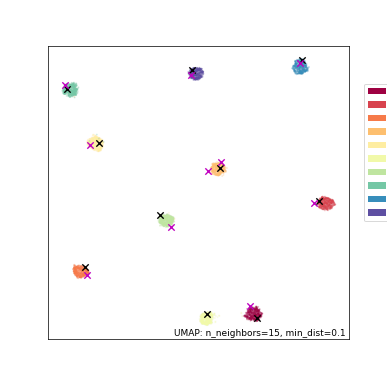

In [25]:
ax = umap.plot.points(mapper, labels=labels, alpha=0.2)
legend = ax.get_legend()
ax.legend(legend.legendHandles, (x.get_text() for x in legend.get_texts()), loc=(1.05,0.4))
# add in the embeddings of the means
embedding1 = mapper.transform(gmm.means_)
ax.scatter(embedding1[:,0], embedding1[:,1], c='k', s=50, marker='x')
# add in the embeddings of the MHN trained memories
embedding2 = mapper.transform(mem)
ax.scatter(embedding2[:,0], embedding2[:,1], c='m', s=50, marker='x')
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.show()

In [148]:
embedding1

array([[ 8.024543  , -2.033245  ],
       [ 7.2937584 , -0.91226673],
       [-3.00771   , -0.9892868 ],
       [ 1.176055  ,  8.370666  ],
       [ 7.0911403 ,  0.97683364],
       [-0.726802  ,  6.780347  ],
       [-3.8032126 , 10.43246   ],
       [14.468044  ,  8.708441  ]], dtype=float32)

In [149]:
embedding2

array([[14.152458 ,  8.708211 ],
       [ 8.806653 ,  1.0071833],
       [ 7.035725 ,  1.4356577],
       [ 6.96794  , -1.706038 ],
       [-3.2108738, -1.3953078],
       [ 8.242613 , -1.41348  ],
       [ 1.355372 ,  7.8508105],
       [-0.9297952,  7.3035555]], dtype=float32)

In [150]:
print(gmm.means_[0])
print(gmm.means_[1])
print(gmm.means_[6])

[-2.  0.  0. -2.  0. -2.  0. -2.  2. -2.]
[-2.  0. -2. -2. -2.  0.  0. -2.  2.  0.]
[ 0.  0. -2.  2. -2. -2. -2.  2.  0.  2.]


In [151]:
print(mem[1])
print(mem[3])
print(mem[5])

[1.361295  1.6545006 1.0529473 1.547332  0.8898108 1.1187481 1.410739
 1.5266416 2.1115546 1.4694259]
[-1.6997694 -1.5074183 -1.5809532 -1.4374664 -1.2174795 -1.300606
 -1.7396959 -1.8028961 -1.0851192 -1.5259272]
[-1.2598946   0.5394309   0.9417635  -2.1709542  -0.4879575  -0.3914527
  0.9098282  -0.85744864  1.9774061   0.08838045]


In [26]:
import os
modeldir = '/data/leslie/sinhaa2/cellmem/models/marrow/'
if not os.path.exists(modeldir):
    os.mkdir(modeldir)
# np.save(modeldir+'mems.npy', mem)

model.save(modeldir+'temp.h5')